In [1]:
import itertools
import functools
import collections
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import sys
from datetime import datetime
import visa
import logging
import time

rm = visa.ResourceManager()
rm.list_resources()
rm.close()
from agilentpyvisa.B1500 import *


exception_logger.setLevel(logging.WARN)
write_logger.setLevel(logging.WARN)
query_logger.setLevel(logging.WARN)

In [2]:
b15= B1500('GPIB1::17::INSTR')

for c in b15.sub_channels:
    print(c,b15.slots_installed[int(str(c)[0])].name)
b15.default_check_err=False

101 HVSPGU
102 HVSPGU
2 HRSMU
3 HRSMU
4 HRSMU
5 HRSMU
6 MFCFMU


In [32]:
SMU1=2 # B
SMU2=3 # C
SMU3=4 # D
SMU4=5 # E
def get_R(d):
    R = d['EV']/d['EI']
    R=R.replace([np.inf, -np.inf], np.nan).dropna()
    return R.abs().mean()

def get_pulse(base, peak, width,count=1, lead_part=0.8, trail_part=0.8, loadz=1e6,gate=1.85, ground=SMU2):
    """Defines a SPGU setup and a channel to go with it, based on the given parameters"""
    mspgu=SPGU(base, peak,width, loadZ=loadz, pulse_leading=[lead_part*width], pulse_trailing=[trail_part*width],condition=count )
    inp_channel=Channel(number=101,spgu=mspgu)
    ground_channel=Channel(number=ground,dcforce=DCForce(Inputs.V,0,.1))
    gate_channel = Channel(number=SMU3,dcforce=DCForce(Inputs.V,gate,.1))
    spgu_test=TestSetup(channels=[ground_channel, gate_channel, inp_channel,],spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.connect_relay_SPGU)])
    return (spgu_test,mspgu, inp_channel, ground_channel, gate_channel)

def get_Vsweep(start, stop, steps, compliance=300e-6,
               measure_range=MeasureRanges_I.full_auto,gate_voltage=1.85, ground=SMU2):
    swep_smu=b15.slots_installed[b15._B1500__channel_to_slot(3)]
    in_range=swep_smu.get_mincover_V(start,stop)
    
    sweep_measure=MeasureStaircaseSweep(Targets.I,range=measure_range, side=MeasureSides.current_side)
    
    sweep = StaircaseSweep(Inputs.V,InputRanges_V.full_auto,start,stop,steps,compliance, auto_abort=AutoAbort.disabled)
    
    inp_channel=Channel(number=SMU4,staircase_sweep=sweep, measurement=sweep_measure)
    
    ground_channel=Channel(number=ground,
                           dcforce=DCForce(Inputs.V,0,compliance),
                           #measurement=sweep_measure
                          )
    
    gate_channel = Channel(number=SMU3,dcforce=DCForce(Inputs.V,gate_voltage,.1),
                          # measurement=MeasureStaircaseSweep(Targets.V,
                          #                                   range=measure_range,
                          #                                   side=MeasureSides.voltage_side)
                          )
    
    sweep_test=TestSetup(channels=[gate_channel,ground_channel,inp_channel],
                         spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.connect_relay_SMU)],
                        output_mode=OutputMode.with_primarysource,
                        format=Format.ascii13_with_header_crl, filter=Filter.enabled)
    return (sweep_test,sweep, inp_channel, ground_channel, gate_channel)

def plot_output(out, t='line',up='b',down='r'):
    lout = out[['EV','EI']]
    lout=lout[lout.applymap(lambda x: not np.isnan(x)).all(axis=1)]
    y=lout['EI'].abs()*1e6
    x=np.array(lout['EV'])
    half = lout['EV'].abs().idxmax()
    if t=='line':
        plt.plot(x[:half],y[:half], color=up,marker='o')
        plt.plot(x[half:],y[half:], color=down,marker='o')
    elif t=='scatter':
        plt.scatter(x[:half],y[:half], color=up,marker='o')
        plt.scatter(x[half:],y[half:], color=down,marker='o')
        
    plt.autoscale()

def form(forming_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    forming_setup,forming, _ , ground_channel,gate_channel=get_Vsweep(start=0,stop=forming_v,
                                                                      steps=steps,compliance=compliance,
                                                                     measure_range=mrange,
                                                                     gate_voltage=gate)
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    ret,out =b15.run_test(forming_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    plot_output(out, up='c',down='m')
    print(out.describe())
    return out

    
def read(start=200e-6,stop=350e-6, steps=51,mrange=MeasureRanges_I.full_auto,  gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    read_setup,read, _ ,ground_channel,gate_channel=get_Vsweep(start=start,stop=stop,steps=steps,
                                                                     measure_range=mrange,
                                                              gate_voltage=gate
                                                              )
    ret,out =b15.run_test(read_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out, up='c',down='m')
    print(out.describe())
    return out

def checkR(start=200e-6,stop=350e-6, steps=51,mrange=MeasureRanges_I.uA100_limited,  gate=1.85, pr=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    read_setup,read, _ ,ground_channel,gate_channel=get_Vsweep(start=start,stop=stop,steps=steps,
                                                                     measure_range=mrange,
                                                              gate_voltage=gate
                                                              )
    ret,out =b15.run_test(read_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    R=get_R(out)
    if pr:
        print(R)
    return R
    
def set_sweep(set_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    set_setup,set, _ ,ground_channel,gate_channel=get_Vsweep(start=0,stop=set_v,steps=steps, compliance=compliance,
                                                                     measure_range=mrange,gate_voltage=gate)
    ret,out =b15.run_test(set_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out, up='c',down='m')
    print(out.describe())
    return out
    
def reset_sweep(reset_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    reset_setup,reset, _ ,ground_channel,gate_channel=get_Vsweep(start=0,stop=reset_v,steps=steps,compliance=compliance,
                                                                     measure_range=mrange,gate_voltage=gate, ground=SMU1)
    ret,out =b15.run_test(reset_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out)
    print(out.describe())
    return out


def pulse(p_v, width, slope, gate=1.85,ground=SMU2,loadZ=1e6):
    reset_pulse_setup, reset_pulse,_,_,_= get_pulse(0,p_v,width,
                                                    lead_part=slope,trail_part=slope,gate=gate,
                                                    ground=ground,loadZ=loadZ
                                                   )
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SPGU)
    b15.run_test(reset_pulse_setup,force_wait=True,force_new_setup=True)
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)

    
LOWRES = 0
HIGHRES = 1
def run_pulses(formV=3, setV=1, resV=-1,spV=1,rpV=-1, width=100e-6, compliance=1e-3,slope=0.8, cycles=50):
    runs =[]
    i=0
    f=form(formV,100,compliance, mrange=MeasureRanges_I.uA10_limited)
    run.append((i,f))
    i+=1
    high_resistance=[]
    low_resistance=[]
    for i in range(5):
        r=reset_sweep(resV, 100, compliance, mrange=MeasureRanges_I.uA10_limited)
        high_resistance.append(get_R(r))
        runs.append((i,r))
        i+=1
        
        s=set_sweep(setV, 100, compliance, mrange=MeasureRanges_I.uA10_limited)
        low_resistance.append(get_R(s))
        runs.append((i,s))
        i+=1
    high_resistance=sum(high_resistance)/len(high_resistance)
    low_resistance=sum(low_resistance)/len(low_resistance)
    STATE = LOWRES
    while _ in range(cycles):
        if STATE == LOWRES:
            resetpulse(rpV, width, slope)
            R=read( mrange=MeasureRanges_I.uA10_limited)
            runs.append((i,R))
            i+=1
            if abs(get_R(R)-high_resistance)/high_resistance<= TRESH:
                STATE = HIGHRES
            else:
                STATE = HIGHRES
        elif STATE == HIGHRES:
            setpulse(spV, width, slope)
            R=read( mrange=MeasureRanges_I.uA10_limited)
            runs.append((i,R))
            i+=1
            if abs(get_R(R)-low_resistance)/low_resistance<= TRESH:
                STATE = LOWRES
            else:
                STATE= HIGHRES
        

def pulse_cycle(rV=-0.5,sV=0.8,width=1e-3,slope=0.8,pr=True,gateReset=1.85,gateSet=1.85,loadZreset=1e6,loadZset=1e6):
    pre_reset =checkR(pr=pr)
    pulse(rV, width, slope,ground=SMU1,gate=gateReset,loadZ=loadZreset)
    post_reset = checkR(pr=pr)
    pre_set = checkR(pr=False)
    pulse(sV, width,slope,gate=gateSet,loadZ=loadZset)
    post_set=checkR(pr=pr)
    return (pre_reset, post_reset,pre_set,post_set)

def pulse_iter(rV=-0.5,sV=0.8,width=1e-3,slope=0.8,max_iter=100,pr=True, abort_break=True,gateReset=1.85, gateSet=1.85):
    i=0
    while True:
        #if i%100 == 0:
        #    print('Iteration ',i)
        pR,poR,pS,poS = pulse_cycle(rV,sV,width,slope,pr=pr,gateReset=gateReset, gateSet=gateSet)
        yield (pR,poR,pS,poS)
        if (abort_break  and np.log10(poR/poS) < 1) or i>=max_iter:
            
            break
        else:
            i+=1
    raise StopIteration
    

def check_width(w,it,rV=-0.5,sV=0.8,slope=0.8,plot=True, abort_break=True,gateReset=1.85,gateSet=1.85):
    c3=pd.DataFrame(np.fromiter(pulse_iter(width=w,max_iter=it,rV=rV,sV=sV,slope=slope,pr=False,
                                           abort_break=abort_break,
                                           gateReset=gateReset,
                                          gateSet=gateSet),
                      dtype=[('preReset',np.float),('postReset',np.float),('preSet',np.float),('postSet',np.float)]))
    print(c3.describe())
    if plot:
        c3.plot()
    return c3
def plot_pyramid(data, x_name, size=None):
    fig, ax1 = plt.subplots(figsize=size)
    for y in [x for x in data.columns if not x_name==x]:
        ax1.plot(data[y],label=y)
        ax1.set_yscale('log')
        ax1.set_ylabel("Resistance")
        ax1.set_xlabel("Cycle")
    ax2=ax1.twinx()
    ax2.scatter(range(len(data[x_name])),data[x_name], label=x_name)
    ax2.set_ylabel(x_name)
    ax2.set_ylim()
    plt.legend(loc='best')

def unit(u):
    if u[0]=='m':
        return 1e-3
    elif u[0]=='u':
        return 1e-6
    elif u[0]=='n':
        return 1e-9

def pyramid_width(widths=[],time_si='us',rV=-500,sV=800,voltage_si='mV',slope=0.8,times=10, abort_break=True,gate=1.85):
    resetV=rV*unit(voltage_si)
    setV=sV*unit(voltage_si)
    datas=[]
    for w in widths:
        width = w*unit(time_si)
        d=check_width(width, times,rV=resetV,sV=setV,slope=slope,plot=False, abort_break=abort_break,gate=gate)
        d['width']=    pd.Series((width for _ in range(len(d))),index=d.index)
        datas.append(d)
    data = pd.concat(datas)
    data.index=range(len(data))
    data.to_csv('{}pyramid_reset{}{}_set{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            resetV/unit(voltage_si),voltage_si,
                                                                            setV/unit(voltage_si),voltage_si,
                                                                            slope/1e-2
                                                                           )
        )
    plot_pyramid(data,[20,10])
    return data

def pyramid_voltage(voltages=[],gate_voltages_reset=[1850],
                    gate_voltages_set=[1850],voltage_si='mV',w=50,time_si='us',slope=0.8,times=10, abort_break=True):
    datas=[]
    iteration=0
    end=len(voltages)*len(gate_voltages)+1
    time_per_run=None
    for gR,gS in zip(gate_voltages_reset,gate_voltages_set):
        for rV,sV in voltages:
            start=time.time()
            print("Iteration ",
                  iteration,
                  " of ",
                  end)
            if time_per_run:
                print(
                      'estimated end',
                      time.strftime('%H:%M:%S',
                                    time.localtime(start+time_per_run*(end-iteration))
                                    ),
                      " time per run:",
                      time_per_run,
                      "seconds"
                     )
            d=None
            width=w*unit(time_si)
            resetV=rV*unit(voltage_si)
            setV=sV*unit(voltage_si)
            gateReset=gR*unit(voltage_si)
            gateSet=gS*unit(voltage_si)
            print("Running:")
            print("width:",width)
            print('lead/trail:',slope*width)
            print('resetV:',resetV)
            print('setV:',setV)
            print('gateSet:',gateSet,voltage_si)
            print('gateReset:',gateReset,voltage_si)
            
            try:
                d=check_width(width, times,rV=resetV,sV=setV,slope=slope,plot=False,
                              abort_break=abort_break,gateReset=gateReset,
                             gateSet=gateSet)
            except BaseException:
                continue
            if d is not None:
                d['rV']=    pd.Series((resetV for _ in range(len(d))),index=d.index)
                d['sV']=    pd.Series((setV for _ in range(len(d))),index=d.index)
                d['gateReset']=  pd.Series((gateReset for _ in range(len(d))),index=d.index)
                d['gateSet']=  pd.Series((gateSet for _ in range(len(d))),index=d.index)
                d['width']= pd.Series((width for _ in range(len(d))),index=d.index)
                d['slope']= pd.Series((slope for _ in range(len(d))),index=d.index)
                datas.append(d)
            iteration+=1
            time_per_run=time.time()-start
    d=None
    try: 
        d=check_width(width, times,rV=voltages[0][0]*unit(voltage_si),
                      sV=voltages[0][1]*unit(voltage_si),slope=slope,plot=False, abort_break=abort_break,gate=1.85)
    except BaseException:
        pass
    if d is not None:
        d['rV']=    pd.Series((voltages[0][0]*unit(voltage_si) for _ in range(len(d))),index=d.index)
        d['sV']=    pd.Series((voltages[0][1]*unit(voltage_si) for _ in range(len(d))),index=d.index)
        d['gate']=    pd.Series((1.85 for _ in range(len(d))),index=d.index)
        d['width']= pd.Series((width for _ in range(len(d))),index=d.index)
        d['slope']= pd.Series((slope for _ in range(len(d))),index=d.index)
        datas.append(d)

    data = pd.concat(datas)
    data.index=range(len(data))
    data.to_csv('{}pyramid_with{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            width/unit(time_si),time_si,
                                                                            slope/1e-2
                                                                           )
        )
    return data

                 EI             ET          EV
count  2.000000e+02     200.000000  200.000000
mean   4.794832e-05  243108.532000    1.500000
std    4.375641e-05       0.303871    0.876928
min   -5.600000e-08  243108.000000    0.000000
25%    1.000000e-09  243108.300000    0.749937
50%    8.599000e-05  243108.600000    1.500000
75%    8.912750e-05  243108.800000    2.250063
max    9.006000e-05  243109.000000    3.000000
2429.969563686493


2429.969563686493

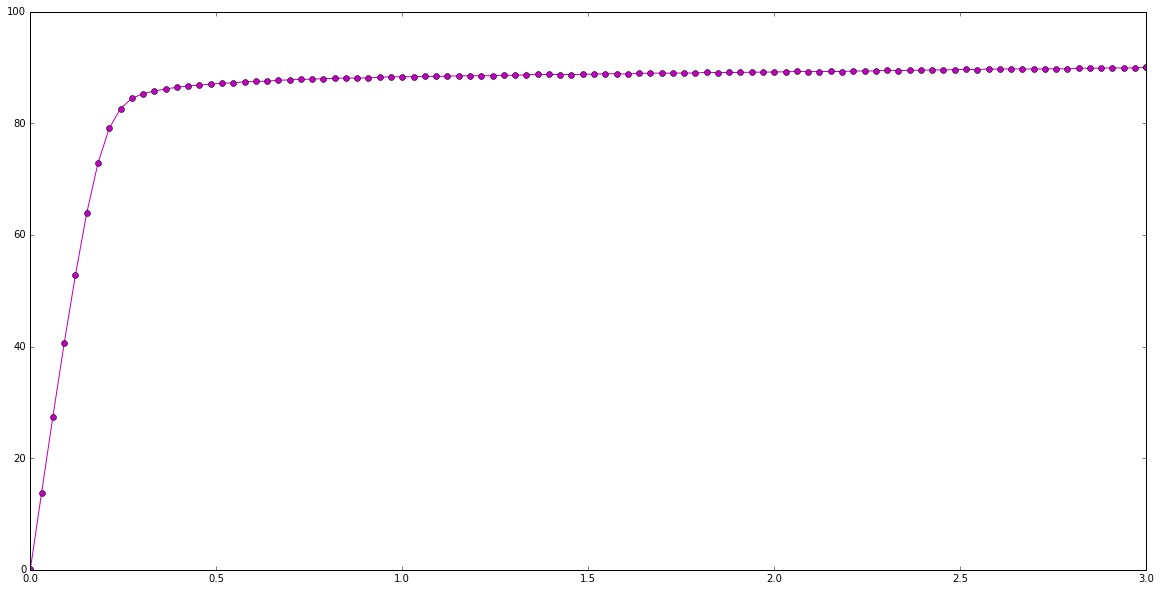

In [26]:
form_sweep= plt.figure(figsize=[20,10])
f=form(3,100,10e-3, mrange=MeasureRanges_I.uA10_limited)
f.to_csv("{}_form_3V.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
plt.autoscale()
checkR()

                 EI             ET          EV
count  2.000000e+02     200.000000  200.000000
mean  -1.287200e-04  243124.829500   -0.750000
std    8.093175e-05       0.280666    0.438458
min   -2.874500e-04  243124.300000   -1.500000
25%   -2.059500e-04  243124.600000   -1.125000
50%   -1.367000e-04  243124.800000   -0.750000
75%   -5.266125e-05  243125.100000   -0.375000
max   -3.500000e-09  243125.300000    0.000000
19995.581737849778
                 EI             ET          EV
count  2.000000e+02     200.000000  200.000000
mean   5.930438e-05  243127.876000    0.500001
std    3.172590e-05       0.268298    0.292322
min   -4.500000e-09  243127.400000    0.000000
25%    2.790000e-05  243127.700000    0.249975
50%    8.111500e-05  243127.900000    0.500050
75%    8.680125e-05  243128.100000    0.750025
max    8.781500e-05  243128.300000    1.000000
7828.378321025379
                 EI           ET          EV
count  2.000000e+02     200.0000  200.000000
mean  -1.254782e-04  243131

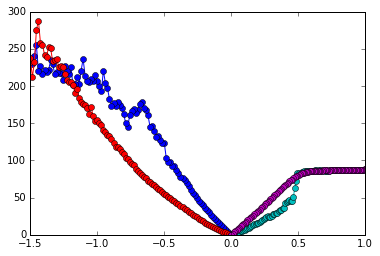

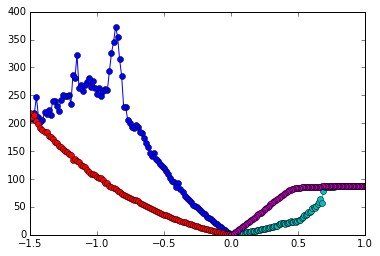

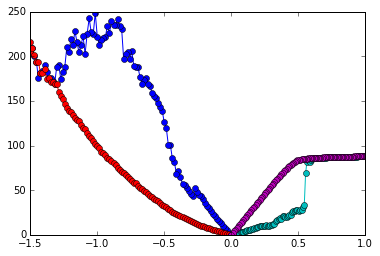

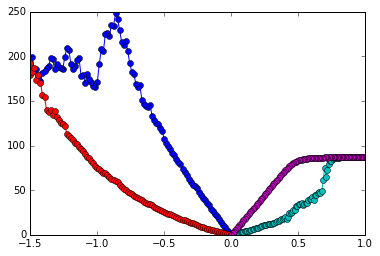

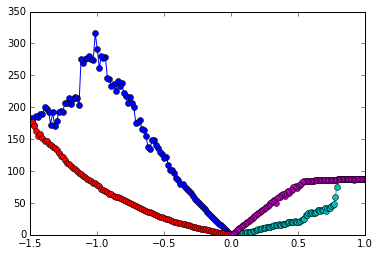

In [28]:
iters=5
for i in range(iters):
    plt.figure()
    plt.hold(True)
    rt=reset_sweep(-1.5,100,5e-3,gate=1.85, mrange=MeasureRanges_I.uA10_limited)
    rt.to_csv("{}_reset{}_-1_5V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),i)
             )
    checkR()
    s=set_sweep(1,100,10e-3, mrange=MeasureRanges_I.uA10_limited)
    s.to_csv("{}_set{}_1V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),i)
            )
    checkR()
    plt.hold(False)

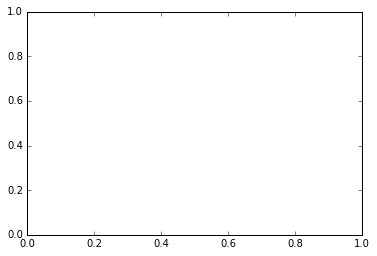

In [29]:
plt.hold()

In [30]:
def norm(d):
    parameters=['sV','rV','gateSet','gateReset','slope','width']
    data=[c for c in d.columns if c not in parameters ]
    d_par = d[parameters]
    d_dat = d[data]
    d_dat_norm= (d_dat-d_dat.mean())/(d_dat.max()-d_dat.min())
    return pd.merge(d_dat_norm,d_par,left_index=True,right_index=True)
    

In [ ]:
voltage_si='mV'
resetV=-500*unit(voltage_si)
setV=800*unit(voltage_si)

time_si='us'
width=100*unit(time_si)

times=10
slope=0.8
d=check_width(width, 1,rV=resetV,sV=setV,slope=slope,abort_break=False)
d.to_csv('{}_{}pulses_reset{}{}_set{}{}_width{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            times,
                                                                            resetV/unit(voltage_si),voltage_si,
                                                                            setV/unit(voltage_si),voltage_si,
                                                                            width/unit(time_si),time_si,
                                                                            slope/1e-2
                                                                           )
        )

In [31]:
baseV = (-500,800)
basegate=1850
r,s=baseV
cycles_per_test=5
percentages=list(reversed(range(40,101,10)))
gate_voltages=[basegate]#* p/100 for p in percentages]
print("Percentages",percentages)
print("Gate Voltages",gate_voltages)
rL=[r*i/100 for i in percentages]
sL=[s*i/100 for i in percentages]
pyr=list(itertools.product(rL,sL))
print("Num_it",len(pyr)*len(gate_voltages))
vpyr=pyramid_voltage(pyr,
                     times=cycles_per_test,
                     gate_voltages_set=gate_voltages,
                     gate_voltages_reset=[basegate for i in range(len(gate_voltages))],
                     voltage_si='mV',
                     abort_break=False)

Percentages [100, 90, 80, 70, 60, 50, 40]
Gate Voltages [1850.0, 1665.0, 1480.0, 1295.0, 1110.0, 925.0, 740.0]
Num_it 343
Iteration  0  of  344
Running:
width: 4.9999999999999996e-05
lead/trail: 3.9999999999999996e-05
resetV: -0.5
setV: 0.8
gateSet: 1.85 mV
gateReset: 1.85 mV
          preReset    postReset       preSet      postSet
count     6.000000     6.000000     6.000000     6.000000
mean   2137.241266  1155.281061  1168.355931  1155.042727
std    2428.264870     8.951668    14.880055    19.007340
min    1135.639271  1146.839328  1149.042331  1127.167345
25%    1140.262847  1148.840551  1157.957891  1146.119037
50%    1148.446385  1153.281185  1169.295312  1152.780374
75%    1156.732134  1158.362315  1176.966513  1171.548214
max    7093.886506  1170.868305  1188.800303  1175.825514
Iteration  1  of  344
estimated end 12:16:00  time per run: 24.93400001525879 seconds
Running:
width: 4.9999999999999996e-05
lead/trail: 3.9999999999999996e-05
resetV: -0.5
setV: 0.72
gateSet: 1.85 mV


In [33]:
vpyr_norm=norm(vpyr)

C:\Users\krawczuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.85, right=1.85
  'left=%s, right=%s') % (left, right))
C:\Users\krawczuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=5e-05, right=5e-05
  'left=%s, right=%s') % (left, right))
C:\Users\krawczuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.8, right=0.8
  'left=%s, right=%s') % (left, right))
C:\Users\krawczuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A036E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EEF7B38>]], dtype=object)

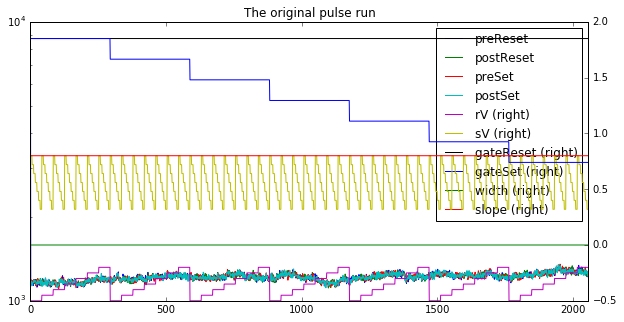

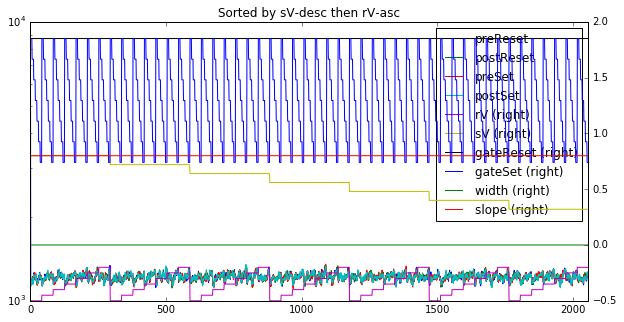

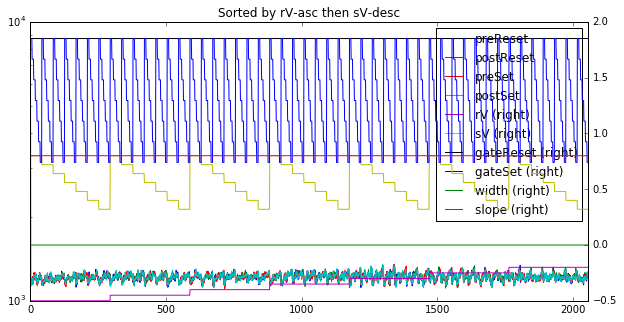

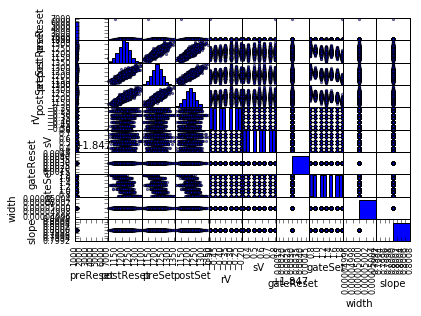

In [34]:
%matplotlib inline
vpyr.plot(logy=[True,True], secondary_y=['rV','sV','gateReset','gateSet','width','slope'],figsize=[10,5], title="The original pulse run")

sortpyr=vpyr.sort_values(['sV','rV'],ascending=[False,True])
sortpyr.index=range(len(sortpyr))
sortpyr.plot(logy=[True,True], secondary_y=['rV','sV','gateReset','gateSet','width','slope'],figsize=[10,5], title="Sorted by sV-desc then rV-asc")

sortpyr2=vpyr.sort_values(['rV','sV'],ascending=[True,False])
sortpyr2.index=range(len(sortpyr2))
sortpyr2.plot(logy=[True,True], secondary_y=['rV','sV','gateReset','gateSet','width','slope'],figsize=[10,5], title="Sorted by rV-asc then sV-desc")


pd.tools.plotting.scatter_matrix(vpyr)

In [ ]:
%matplotlib inline
plt.figure(figsize=[10,10])
#plt.yscale('lin')
pd.tools.plotting.parallel_coordinates(vpyr_norm[[g for g in vpyr_norm.columns if g not in ['width','slope','gateReset']]],'gateSet')

In [ ]:
grouping_variables=['sV','rV',]
trivial=['width','slope','gateReset']
grps=vpyr_norm.groupby(grouping_variables)
#grps.plot()

In [ ]:
%matplotlib inline
for key,g in grps:
    
    g_sel=g[[x for x in g.columns if x not in grouping_variables+trivial]]
    plt.figure(figsize=[10,5])
    groupvar='gateSet'
    pd.tools.plotting.parallel_coordinates(g_sel,groupvar)
    #plt.yscale('log')
    plt.title(' '.join(['{}:{}'.format(l,v) for l,v in zip(grouping_variables,key)]+['groupedBy:{}'.format(groupvar)]))

    #.plot(logy=[True,True],
    #       figsize=[10,5], title='{}'.format({l:v for l,v in zip(grouping_variables,key)}))

grps.describe()

In [ ]:
grps[['postSet','postReset']].var().plot(figsize=[10,5])